### 1. Import library

In [1]:
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import os
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import models
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from ViT import CustomViTFusionModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\thanh\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### 2. Define transform

- **Resize**: điều chỉnh kích thước của ảnh về (224, 224) -> thuận tiện cho việc huấn luyện thông qua Vision Transformer.
- **ToTensor**: chuyển đổi hình ảnh PIL hoặc NumPy ndarray thành FloatTensor. và chia tỷ lệ các giá trị cường độ điểm ảnh của hình ảnh trong phạm vi [0., 1.]

> Link: [Transforms](https://docs.pytorch.org/vision/0.9/transforms.html)

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    # transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
])

### 3. Demo image: Hiển thị ảnh trước và sau khi transform.

Ảnh gốc
(640, 480)


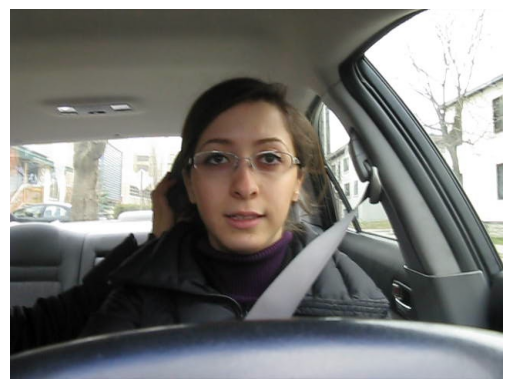

In [3]:
print("Ảnh gốc")
example = Image.open("0 FaceImages/Active Subjects/Active_0.jpg")
print(example.size)
plt.imshow(example)
plt.axis("off")
plt.show()

Ảnh sau khi chỉnh sửa
torch.Size([3, 224, 224])


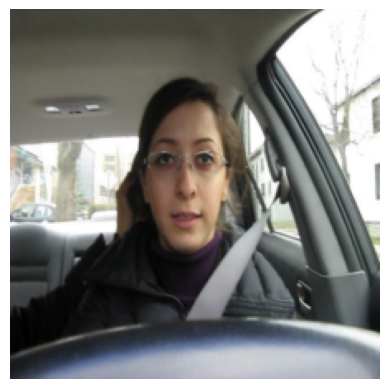

In [4]:
print("Ảnh sau khi chỉnh sửa")
transformed_image = transform(example)
print(transformed_image.shape)
plt.imshow(transformed_image.permute(1, 2, 0))
plt.axis("off")
plt.show()

### 4. Normalize eda, hr, temp

- **Người bình thường**:
    + Eda: [20 * 10^-6, 0.5] (đơn vị: S)
    + Heart Rate (hr): [60, 100] (đơn vị: nhịp / phút)
    + Temperature: [36, 37.5] (đơn vị: ℃)

- **Người không được khỏe**: Eda, Heart Rate và Temperature không nằm trong khoảng trên.

In [5]:
def normalize(eda, hr, temp):
    # Chuẩn hóa theo min-max:
    eda = (eda - 20e-6) / (0.5 - 20e-6)
    hr = (hr - 60) / (100 - 60)
    temp = (temp - 36) / (37.5 - 36)
    
    return eda, hr, temp

### 5. Create Dataset

- **1 tập dữ liệu có độ dài 9120, và 1 dữ liệu đính kèm ảnh, nhãn, 3 thông tin eda, hr, temp đã được chuẩn hóa**.
- **Lưu ý**: Ảnh của người được phép lái xe nằm trong thư mục Active Subjects và có nhãn (label) là 1, ngược lại ảnh của người không được phép lái xe nằm trong thư mục Fatigue Subjects và có nhãn (label) là 0.

In [6]:
class FacePhysio(Dataset):
    def __init__(self, active_dir: str, fatigue_dir: str, eda: str, hr: str, temp: str, transform: None):
        self.transform = transform
        
        # Lưu trữ file ảnh
        self.image_paths = []
        # Lưu trữ nhãn của ảnh
        self.labels = []
        
        # Lấy ra các file ảnh có trong 2 thư mục active_dir và fatigue_dir
        self.active_paths = [os.path.join(active_dir, image_path) for image_path in os.listdir(active_dir)]
        self.fatigue_paths = [os.path.join(fatigue_dir, image_path) for image_path in os.listdir(fatigue_dir)]
        
        self.image_paths = self.active_paths + self.fatigue_paths
        
        # Label = 1 ứng với ảnh có trong thư mục Active Subjects, label = 0 ứng với ảnh có trong thư mục Fatigue Subjects
        self.labels = [1] * len(self.active_paths) + [0] * len(self.fatigue_paths)
        
        # Đọc file csv
        self.eda = pd.read_csv(eda)
        self.hr = pd.read_csv(hr)
        self.temp = pd.read_csv(temp)
                
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Lấy ra bức ảnh ứng với vị trí idx
        image = Image.open(self.image_paths[idx]).convert("RGB")
        # Nếu có transform thì transform ảnh
        if self.transform:
            image = self.transform(image).to(device)
            
        # Lây ra nhãn của ảnh ứng với vị trí idx
        label = self.labels[idx]
        
        # Lấy ra eda, hr, temp của ảnh ứng với vị trí idx
        eda = self.eda.iloc[idx]["EDA"]
        hr = self.hr.iloc[idx]["HR"]
        temp = self.temp.iloc[idx]["TEMP"]
        
        # Chuẩn hóa eda, hr, temp
        eda, hr, temp = normalize(eda, hr, temp)
        
        # Lấy ra vector đặc trưng cho bộ dữ liệu eda, hr, temp
        physio_vec = torch.tensor([eda, hr, temp], dtype=torch.float32).to(device)
        
        return image, label, physio_vec


In [7]:
dataset = FacePhysio(active_dir="0 FaceImages/Active Subjects",
                     fatigue_dir="0 FaceImages/Fatigue Subjects",
                     eda="CSV/EDA.csv",
                     hr="CSV/HR.csv",
                     temp="CSV/TEMP.csv",
                     transform=transform)

### 6. Create train and val dataset -> create train and val dataloader

**Mục đích**:
- **Chia tỷ lệ**: Tạo train_dataset và val_dataset với tỷ lệ *8:2*.
- **Nhanh**: Đẩy train_dataset và val_dataset vào DataLoader để giảm thiểu tính toán trên mô hình và xử lý song song (tận dụng khả năng của GPU).

**Batch_size**: là chia nhỏ dataset ra từng batch để xử lý với mỗi batch có kích thước là 32 (nếu len(dataset) = 32 mà batch_size=32 thì len(dataloader) = 32 / 32 = 1).

**Lưu ý**: không nên sử dụng random_split của torch.utils.data vì nó chỉ random có 1 lần, không phù hợp để train.

> Link: [Dataset & DataLoader](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [8]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train samples:", len(train_dataset))
print("Test samples:", len(val_dataset))

Train samples: 7296
Test samples: 1824


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print("Train dataloader:", len(train_dataloader))
print("Val dataloader:", len(val_dataloader))

Train dataloader: 228
Val dataloader: 57


### 7. ViT

> Link: [ViT](https://arxiv.org/pdf/2010.11929#page=2.73)

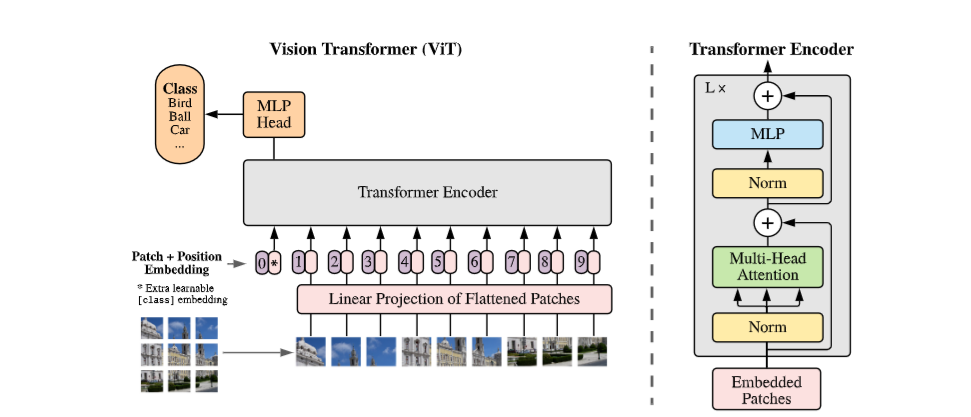

Bao gồm các phần:
- **PatchEmbedding**: chia bức ảnh thành nhiều cửa sổ (dùng Conv2d) sau đó flatten ra để lấy đặc trưng của ảnh.
- **MSA**

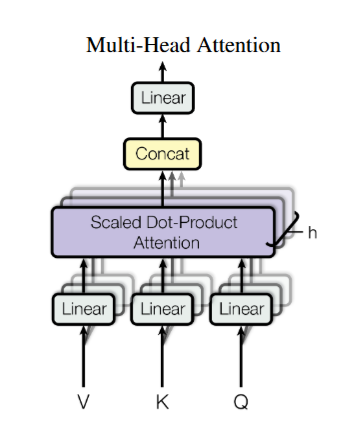 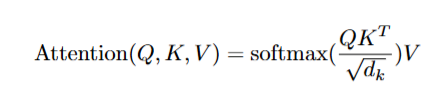
- **MLPBlock**: Layernorm (LN) is applied before every block, and residual connections after every block.

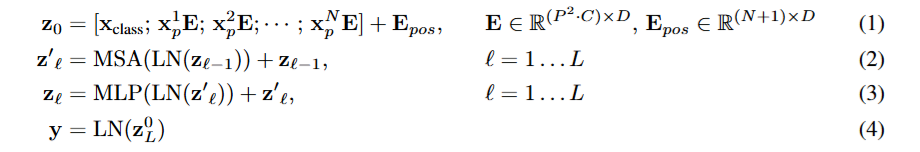

- **TransformerEncoderBlock**: The Transformer encoder consists of alternating layers of multiheaded selfattention and MLP blocks.

**Mô hình của bài toán** bao gồm 2 phần: ViT và Physio
- ViT dùng để trích xuất đặc trưng của ảnh, trong khi Physio ta đã làm trong phần 4. dùng để lấy đặc trưng của eda, hr, temp (bộ dữ liệu sinh trắc học).

In [10]:
model = CustomViTFusionModel(num_classes=2).to(device)

### 8. Train model

In [11]:
def train_model(model, train_dataloader, val_dataloader, epochs: int=10):
    results = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": [],
    }
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        results["all_preds"] = []
        results["all_labels"] = []

        model.train()
        
        total_train_loss = 0
        
        for batch in tqdm(train_dataloader):
            images, labels, physio = batch
            images, labels, physio = images.to(device), labels.to(device), physio.to(device)
            
            optimizer.zero_grad()
            label_pred = model(images, physio)
            loss = criterion(label_pred, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_dataloader)
        results["train_loss"].append(avg_train_loss)
        
        model.eval()
        
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                images, labels, physio = batch
                images, labels, physio = images.to(device), labels.to(device), physio.to(device)
                
                label_pred = model(images, physio)
                loss = criterion(label_pred, labels)
                total_val_loss += loss.item()
                
                preds = torch.argmax(label_pred, dim=1)
                # labels = labels.cpu().numpy()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                results["all_preds"].extend(preds)
                results["all_labels"].extend(labels)
                
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct / total
        
        scheduler.step(val_accuracy)
        
        results["val_loss"].append(avg_val_loss)
        results["val_accuracy"].append(val_accuracy)
        
        torch.save({
            'epoch': epoch,
            # 'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
        }, "checkpoint.ckpt")

        
        print(f"Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")
        
    return results
        

In [12]:
results = train_model(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=3)

Epoch 1/3


100%|██████████| 57/57 [00:12<00:00,  4.61it/s]


Train loss: 0.6801 | Val loss: 0.6207 | Val accuracy: 0.6223
Epoch 2/3


100%|██████████| 57/57 [00:12<00:00,  4.74it/s]


Train loss: 0.5757 | Val loss: 0.4743 | Val accuracy: 0.9808
Epoch 3/3


100%|██████████| 57/57 [00:12<00:00,  4.71it/s]

Train loss: 0.4110 | Val loss: 0.2974 | Val accuracy: 0.9923


### 9. Visualize train_loss, val_loss, val_accuracy

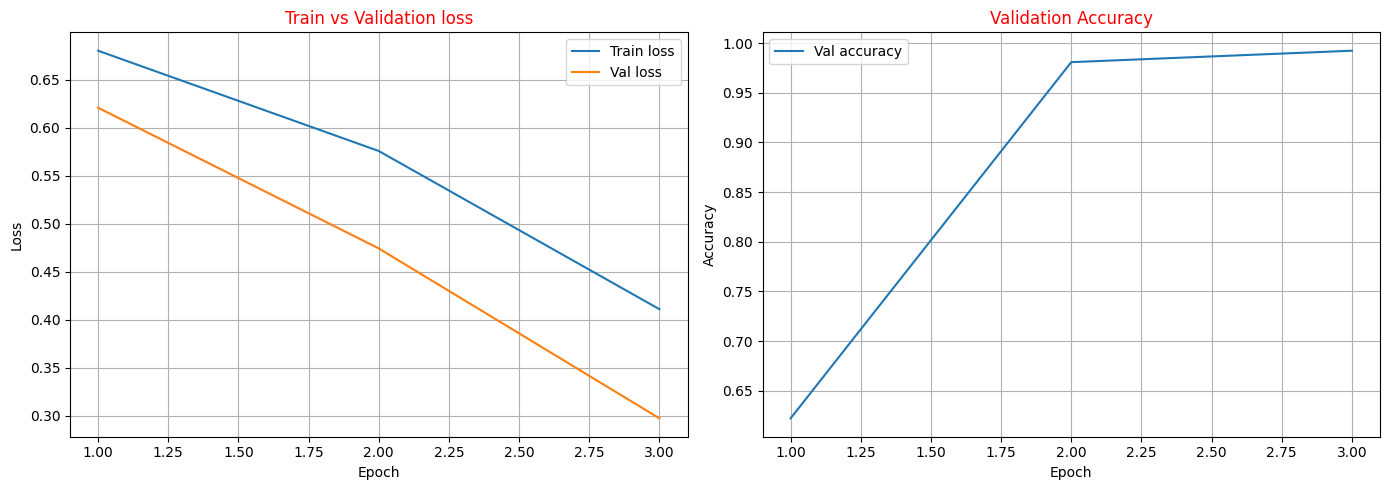

In [13]:
epochs = range(1, len(results["train_loss"]) + 1)
plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, results["train_loss"], label="Train loss")
plt.plot(epochs, results["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation loss", color="r")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, results["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy", color="r")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

**=> Thông qua hình ảnh trên, ta thấy train_loss và val_loss giảm sau từng epoch, còn val_accuracy lại tăng 1 cách rõ rệt. Cho thấy mô hình học rất tốt**.

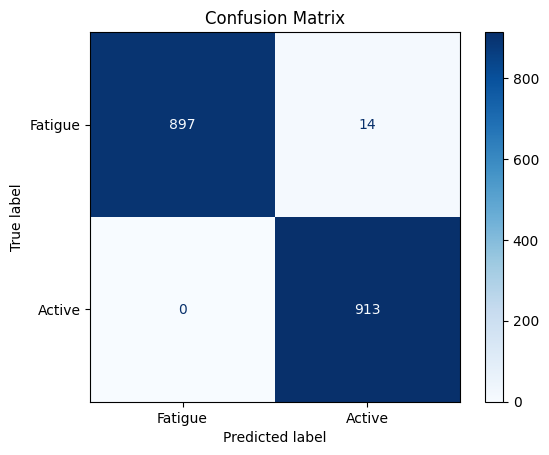

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = torch.stack(results["all_preds"]).cpu().numpy()
labels = torch.stack(results["all_labels"]).cpu().numpy()

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fatigue", "Active"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=["Fatigue", "Active"]))

              precision    recall  f1-score   support

     Fatigue       1.00      0.98      0.99       911
      Active       0.98      1.00      0.99       913

    accuracy                           0.99      1824
   macro avg       0.99      0.99      0.99      1824
weighted avg       0.99      0.99      0.99      1824



### 10. Test

In [16]:
def test_model_on_samples(model, samples, checkpoint_path="checkpoint.ckpt"):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for idx, (image_path, eda, hr, temp, label) in enumerate(samples):
            image = Image.open(image_path).convert("RGB")
            transformed_image = transform(image).unsqueeze(0).to(device)  # [1, 3, H, W]

            n_eda, n_hr, n_temp = normalize(eda, hr, temp)
            
            physio = torch.tensor([n_eda, n_hr, n_temp], dtype=torch.float32).reshape(1, -1).to(device)     # [1, 3]

            output = model(transformed_image, physio)               # [1, num_classes]

            # Nếu output là logits (với CrossEntropyLoss), dùng softmax
            probs = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            accuracy = probs[0][pred_class].item()

            print(f"Mẫu {idx + 1}:")
            print(f"Dự đoán: {pred_class} (chính xác: {accuracy:.4f})")
            if label is not None:
                print(f"Nhãn thật: {label}")

In [17]:
model = CustomViTFusionModel(num_classes=2).to(device)
samples = [
    ("test/1.jpg", 0.43, 88.5, 37, 1),
    ("test/2.jpg", 0.38, 75, 37.4, 1),
    ("test/3.jpg", 0.51, 90, 34, 0),
]

test_model_on_samples(model, samples)

Mẫu 1:
Dự đoán: 1 (chính xác: 0.7356)
Nhãn thật: 1
Mẫu 2:
Dự đoán: 1 (chính xác: 0.7982)
Nhãn thật: 1
Mẫu 3:
Dự đoán: 0 (chính xác: 0.9450)
Nhãn thật: 0


In [21]:
eda, hr, temp = 0.38, 120, 34.6
face_cascade = cv2.CascadeClassifier("haarcascade/haarcascade_frontalface_default.xml")

video_capture = cv2.VideoCapture("test/1.mp4")

prev_frame_time = time.time()
new_frame_time = 0

checkpoint = torch.load("checkpoint.ckpt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

mapping = {0: "drownsy", 1: "non drownsy"}

while video_capture.isOpened():
    ret, frame = video_capture.read()
    
    if not ret:
        print("Finished processing or cannot read the video.")
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.1, 10, minSize=(10, 10))
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        roi_face = frame[y: y + h, x: x + w]
        
        with torch.no_grad():
            image = Image.fromarray(cv2.cvtColor(roi_face, cv2.COLOR_BGR2RGB)).convert("RGB")
            transformed_image = transform(image).unsqueeze(0).to(device)  # [1, 3, H, W]

            n_eda, n_hr, n_temp = normalize(eda, hr, temp)
                
            physio = torch.tensor([n_eda, n_hr, n_temp], dtype=torch.float32).reshape(1, -1).to(device)     # [1, 3]

            output = model(transformed_image, physio)               # [1, num_classes]

            # Nếu output là logits (với CrossEntropyLoss), dùng softmax
            probs = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            accuracy = probs[0][pred_class].item()
            
        cv2.putText(frame, mapping[pred_class], (x + 75, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    
    fps_text = f"FPS: {int(fps)}"
    
    cv2.putText(frame, fps_text, (frame.shape[1] - 150, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    
    cv2.imshow("Drowniess Detection in Video with FPS", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
video_capture.release()
cv2.destroyAllWindows()